Epoch 1/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 28s 55ms/step - accuracy: 0.6031 - loss: 1.8635 - val_accuracy: 0.8747 - val_loss: 0.3875
Epoch 2/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 25s 63ms/step - accuracy: 0.8780 - loss: 0.3729 - val_accuracy: 0.9065 - val_loss: 0.2763
Epoch 3/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 25s 62ms/step - accuracy: 0.9070 - loss: 0.2706 - val_accuracy: 0.9207 - val_loss: 0.2318
Epoch 4/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 28s 70ms/step - accuracy: 0.9217 - loss: 0.2298 - val_accuracy: 0.9319 - val_loss: 0.1941
Epoch 5/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 28s 71ms/step - accuracy: 0.9349 - loss: 0.1854 - val_accuracy: 0.9411 - val_loss: 0.1770
Epoch 6/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 27s 66ms/step - accuracy: 0.9429 - loss: 0.1595 - val_accuracy: 0.9480 - val_loss: 0.1527
Epoch 7/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 28s 71ms/step - accuracy: 0.9509 - loss: 0.1453 - val_accuracy: 0.9518 - val_loss: 0.1596
Epoch 8/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.9553 - loss: 0.1266 - 

249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9613 - loss: 0.1398

✅ Test Accuracy: 0.9603
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step

📊 Classification Report:

                              precision    recall  f1-score   support

         allergy, immunology       1.00      1.00      1.00       205
                  bariatrics       0.97      1.00      0.99       204
   cardiovascular, pulmonary       0.89      0.99      0.94       204
                chiropractic       0.96      1.00      0.98       204
       consult, history, phy       1.00      0.99      0.99       204
  cosmetic, plastic, surgery       1.00      0.96      0.98       204
                   dentistry       0.92      0.95      0.93       204
                 dermatology       0.95      1.00      0.98       204
           diets, nutritions       1.00      1.00      1.00       204
          discharge, summary       1.00      0.97      0.98       204
    emergency, room, reports       0.98      0.97      0.97

C:\Users\user\AppData\Local\Temp\ipykernel_5704\3548693902.py:120: UserWarning: Glyph 129534 (\N{RECEIPT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\user\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129534 (\N{RECEIPT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


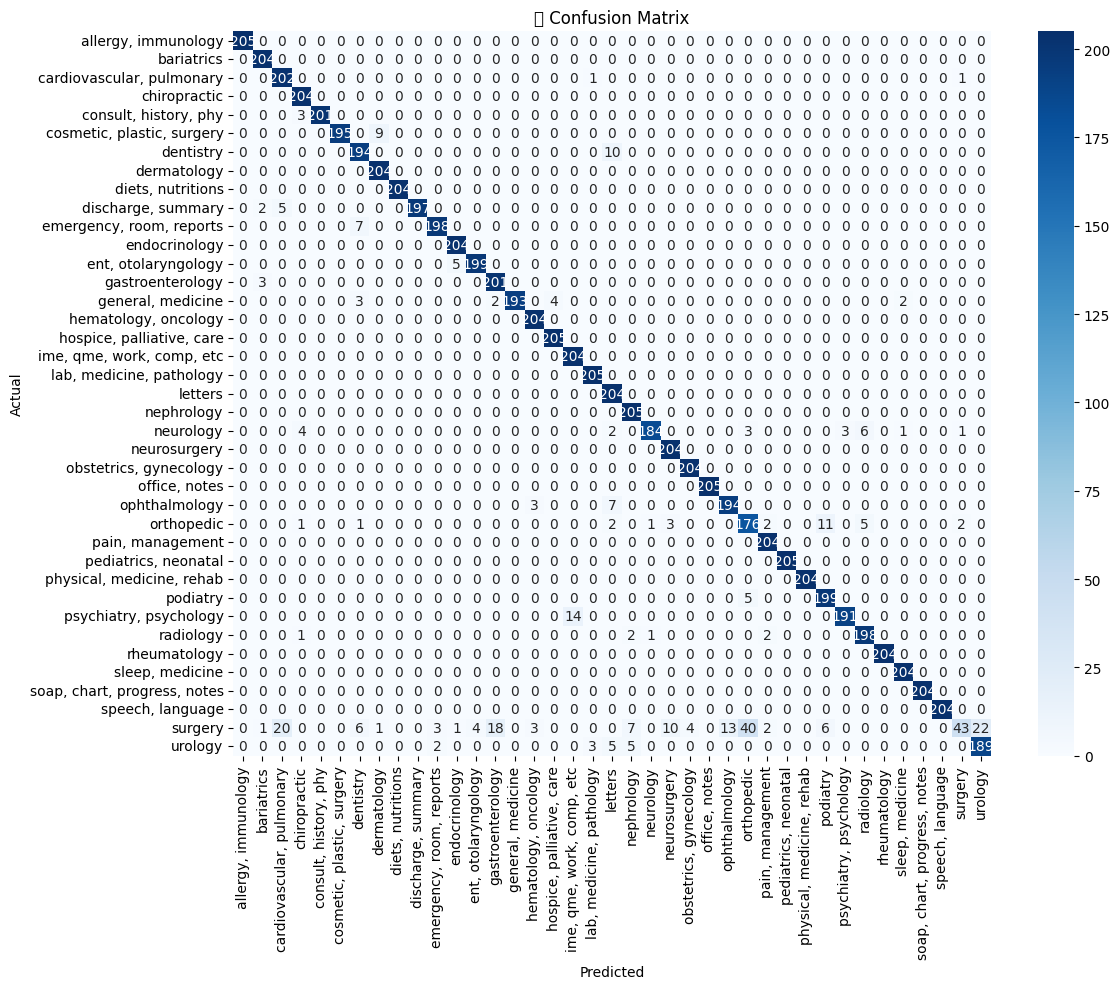


🔁 Prediction Test #1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step

🩺 Predicted Specialty: gastroenterology
🔮 Confidence: 0.8812


In [1]:
import pandas as pd
import numpy as np
import ast
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
import joblib

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import RandomOverSampler

# --------------------- Load and preprocess ---------------------

df = pd.read_csv("data_zwina.csv")

df['keywords'] = df['keywords'].apply(lambda x: ' '.join(ast.literal_eval(x)) if isinstance(x, str) else '')
df['transcription'] = df['transcription'].astype(str)
df['description'] = df['description'].astype(str)
df['sample_name'] = df['sample_name'].astype(str)
df['medical_specialty'] = df['medical_specialty'].astype(str)

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text

df['all_text'] = (
    df['description'] + ' ' +
    df['sample_name'] + ' ' +
    df['keywords'] + ' ' +
    df['transcription']
).apply(preprocess_text)

# --------------------- Vectorization ---------------------

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X = vectorizer.fit_transform(df['all_text']).toarray()

# Save vectorizer AFTER fitting ✅
joblib.dump(vectorizer, "vectorizer.pkl")

# --------------------- Target encoding ---------------------

specialties = sorted(df['medical_specialty'].unique())
specialty_to_index = {name: i for i, name in enumerate(specialties)}
index_to_specialty = {i: name for name, i in specialty_to_index.items()}

# Save index-to-specialty map ✅
joblib.dump(index_to_specialty, "index_to_specialty.pkl")

y = df['medical_specialty'].map(specialty_to_index).values
y_cat = to_categorical(y, num_classes=len(specialties))

# --------------------- Resampling ---------------------

ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X, y_cat)

# --------------------- Train/test split ---------------------

X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42, stratify=y_res
)

# --------------------- Build and train model ---------------------

model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(512, activation='relu'),
    Dropout(0.4),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(len(specialties), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop]
)

# Save model in both formats ✅
model.save("medical_specialty_model.keras")
model.save("medical_specialty_model.h5")

# --------------------- Evaluation ---------------------

loss, accuracy = model.evaluate(X_test, y_test)
print(f"\n✅ Test Accuracy: {accuracy:.4f}")

y_test_labels = np.argmax(y_test, axis=1)
y_pred_probs = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

report = classification_report(y_test_labels, y_pred_labels, target_names=specialties)
print("\n📊 Classification Report:\n")
print(report)

conf_mat = confusion_matrix(y_test_labels, y_pred_labels)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_mat, xticklabels=specialties, yticklabels=specialties, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("🧾 Confusion Matrix")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# --------------------- Prediction Function ---------------------

def predict_specialty(text_input):
    if not hasattr(predict_specialty, "model"):
        predict_specialty.model = load_model("medical_specialty_model.keras")
    if not hasattr(predict_specialty, "vectorizer"):
        predict_specialty.vectorizer = joblib.load("vectorizer.pkl")
    if not hasattr(predict_specialty, "index_to_specialty"):
        predict_specialty.index_to_specialty = joblib.load("index_to_specialty.pkl")

    processed_text = preprocess_text(text_input)
    processed_vector = predict_specialty.vectorizer.transform([processed_text]).toarray()
    prediction = predict_specialty.model.predict(processed_vector)
    predicted_index = np.argmax(prediction)
    predicted_specialty = predict_specialty.index_to_specialty[predicted_index]
    confidence = prediction[0][predicted_index]

    print(f"\n🩺 Predicted Specialty: {predicted_specialty}")
    print(f"🔮 Confidence: {confidence:.4f}")
    return predicted_specialty, confidence

# --------------------- Test Prediction ---------------------

sample_texts = [
    "A 50-year-old female whose 51-year-old sister has a history of multiple colon polyps, which may slightly increase her risk for colon cancer in the future."
]

for i, text in enumerate(sample_texts, 1):
    print(f"\n🔁 Prediction Test #{i}")
    predict_specialty(text)


In [14]:
model.save("medical_specialty_model.h5")
joblib.dump(vectorizer, "vectorizer.pkl")


['vectorizer.pkl']

In [13]:
sample_texts = [
    "A 50-year-old female whose 51-year-old sister has a history of multiple colon polyps, which may slightly increase her risk for colon cancer in the future."
]

for i, text in enumerate(sample_texts, 1):
    print(f"\n🔁 Prediction Test #{i}")
    predict_specialty(text)



🔁 Prediction Test #1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

🩺 Predicted Specialty: gastroenterology
🔮 Confidence: 0.6822


In [ ]:
model.save("medical_specialty_model.keras")
joblib.dump(vectorizer, "vectorizer.pkl")
joblib.dump(index_to_specialty, "index_to_specialty.pkl")


['index_to_specialty.pkl']

In [20]:
# Save trained model in modern Keras format
model.save("medical_specialty_model.keras")

# Save the trained TF-IDF vectorizer
joblib.dump(vectorizer, "vectorizer.pkl")

# Save the label index-to-specialty mapping
joblib.dump(index_to_specialty, "index_to_specialty.pkl")


['index_to_specialty.pkl']